In [47]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from time import time

# RRT Parameters
step_size = 3.0  # Step size for RRT
max_iter = 1000  # Maximum iterations

In [48]:
# Load the provided point cloud file
point_cloud = o3d.io.read_point_cloud("optimized_point_cloud_with_labels.ply")
points = np.asarray(point_cloud.points)

# Visualize the point cloud dimensions
print(f"Point Cloud Dimensions: {points.shape}")

# Extract obstacle points from the point cloud
obstacles = points  # Treat entire point cloud as obstacles

Point Cloud Dimensions: (11000, 3)


In [49]:
# Function to calculate the Euclidean distance
def distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

# Function to find the nearest node in the tree
def nearest(tree, point):
    distances = np.linalg.norm(tree - point, axis=1)
    return np.argmin(distances)

# Check if a line segment is collision-free
def collision_free(p1, p2, obstacles, step_size=0.5):
    direction = np.array(p2) - np.array(p1)
    distance = np.linalg.norm(direction)
    direction /= distance
    steps = int(distance // step_size)
    for i in range(steps + 1):
        point = p1 + i * step_size * direction
        if np.min(np.linalg.norm(obstacles - point, axis=1)) < 0.5:
            return False
    return True

# Function to generate a random point within the bounds
def random_point(bounds):
    return np.random.uniform(low=bounds[:, 0], high=bounds[:, 1], size=(3,))


In [50]:
# RRT implementation
def rrt(start, goal, obstacles, bounds, max_iter=1000, step_size=3.0):
    tree = [start.astype(np.float64)]  # Ensure tree points are float64
    parents = [-1]
    for _ in range(max_iter):
        # Sample a random point or the goal
        rand_point = random_point(bounds).astype(np.float64)
        if np.random.rand() < 0.1:  # Bias towards goal
            rand_point = goal

        # Find the nearest node
        nearest_index = nearest(np.array(tree), rand_point)
        nearest_point = tree[nearest_index]

        # Move step_size towards the random point
        direction = rand_point - nearest_point
        direction = direction / np.linalg.norm(direction)  # Normalize as float64
        new_point = nearest_point + step_size * direction

        # Check for collisions
        if collision_free(nearest_point, new_point, obstacles):
            tree.append(new_point)
            parents.append(nearest_index)

            # Check if the goal is reached
            if np.linalg.norm(new_point - goal) < step_size:
                tree.append(goal)
                parents.append(len(tree) - 2)
                print(f"Goal reached in {_} iterations")
                return np.array(tree), np.array(parents)
    print("Goal not reached within maximum iterations.")
    return np.array(tree), np.array(parents)

In [51]:
# Function to calculate path length
def calculate_path_length(path):
    return sum(np.linalg.norm(path[i] - path[i - 1]) for i in range(1, len(path)))

# Function to measure time taken
def measure_time(func, *args, **kwargs):
    start_time = time()
    result = func(*args, **kwargs)
    end_time = time()
    elapsed_time = end_time - start_time
    return result, elapsed_time

In [52]:
# Set start and goal points
start = np.array([-8, -8, 0])
goal = np.array([8, 8, 0])

# Define bounds for the search area
bounds = np.array([[np.min(obstacles[:, 0]), np.max(obstacles[:, 0])],
                   [np.min(obstacles[:, 1]), np.max(obstacles[:, 1])],
                   [np.min(obstacles[:, 2]), np.max(obstacles[:, 2])]])

# Run RRT to find a path to the goal
(tree, parents), goal_path_time = measure_time(rrt, start, goal, obstacles, bounds, max_iter=max_iter, step_size=step_size)
goal_path = backtrack(tree, parents)

# Run RRT to find the return path
(return_tree, return_parents), return_path_time = measure_time(rrt, goal, start, obstacles, bounds, max_iter=max_iter, step_size=step_size)
return_path = backtrack(return_tree, return_parents)

# Calculate path lengths
goal_path_length = calculate_path_length(goal_path)
return_path_length = calculate_path_length(return_path)

# Print measurements
print(f"Goal Path Length: {goal_path_length:.2f}")
print(f"Return Path Length: {return_path_length:.2f}")
print(f"Goal Path Time: {goal_path_time:.2f} seconds")
print(f"Return Path Time: {return_path_time:.2f} seconds")

Goal reached in 43 iterations
Goal reached in 48 iterations
Goal Path Length: 31.49
Return Path Length: 31.70
Goal Path Time: 0.11 seconds
Return Path Time: 0.14 seconds


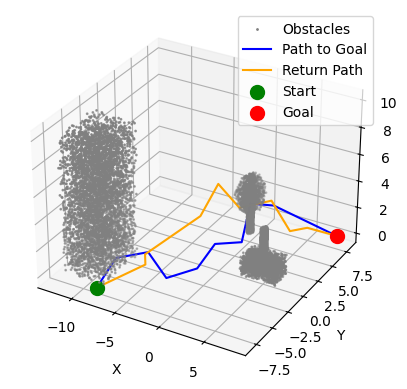

In [53]:
# Plot the paths and obstacles
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot obstacles
ax.scatter(obstacles[:, 0], obstacles[:, 1], obstacles[:, 2], s=1, c='gray', label='Obstacles')

# Plot paths
if len(goal_path) > 1:
    ax.plot(goal_path[:, 0], goal_path[:, 1], goal_path[:, 2], c='blue', label='Path to Goal')
if len(return_path) > 1:
    ax.plot(return_path[:, 0], return_path[:, 1], return_path[:, 2], c='orange', label='Return Path')

# Mark start and goal
ax.scatter(start[0], start[1], start[2], c='green', s=100, label='Start')
ax.scatter(goal[0], goal[1], goal[2], c='red', s=100, label='Goal')

# Set labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()